# PRIMMDebug Log Data Analysis Notebook
This notebook displays all of the analysis of the log data that took place in the PRIMMDebug initial research paper.

The log data was collected from five schools between December 2024-Month 2025. It is divided into the following sections:
1. **Summary statistics:** An overview of the scale of the data and a breakdown of the participants.
2. **Establishing variables:** A closer look at some variables of interest, including time on task and success on the PRIMMDebug challenges.
3. **Cluster analysis:** Documentation of the clustering process.
4. **Students' written responses:** The beginnings of some analysis on the written responses entered by some students

All you need to do is run the notebooks in order and the statistics that appear in the paper will be displayed. If there are any issues, please report them in the [Issues section of the GitHub repository](https://github.com/LaurieGale10/primmdebug-log-data-analysis/issues).

Before we run anything else, let's first import all of the necessary libraries and data.

In [2]:
from classes.stage_log import StageLog
from classes.exercise_log import ExerciseLog
from classes.student_id import StudentId
from classes.exercise_classes.exercise import Exercise
from classes.processors.exercise_log_processor import ExerciseLogProcessor
from classes.processors.stage_log_processor import StageLogProcessor

from loading_services.fetch_logs_from_file import fetch_data_from_json
from loading_services.parse_logs import *

from testing_service.docker_interface import DockerInterface
from testing_service.test_report import TestReport

from constants import *
from notebook_utils import *

import plotly.express as px
from collections import Counter
from statistics import median
from math import isnan
import datetime

#Libraries for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from kmedoids import *
from pandas import DataFrame
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

"""
#Some clustering-related functions don't have good Python implementations, for which R libraries are used instead.
import os
os.environ["R_HOME"] = "C:\\Program Files\\R\\R-4.5.0"
os.environ["R_LIBS_USER"] = "C:\\Program Files\\R\\R-4.5.0\\library"
import rpy2
from rpy2.robjects import default_converter, rinterface, pandas2ri
from rpy2.robjects.packages import importr, isinstalled
from rpy2.robjects.vectors import StrVector

utils = importr('utils')
utils.chooseCRANmirror(ind=1)
packnames = ('clustertend', 'WeightedCluster', 'factoextra')
names_to_install = [x for x in packnames if not isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))
"""

print("Loading logs")
EXERCISES: list[Exercise] = parse_exercises(fetch_data_from_json("data/exercises"))
STAGE_LOGS: list[StageLog] = parse_stage_logs(fetch_data_from_json("data/cleaned_stage_logs"))
EXERCISE_LOGS: list[ExerciseLog] = parse_exercise_logs(STAGE_LOGS, fetch_data_from_json("data/cleaned_exercise_logs"))
STUDENT_IDS: list[StudentId] = parse_student_ids(fetch_data_from_json("data/student_ids"))

print("Adding test harness data")
#Initiate Docker container
run_tests: bool = False
if run_tests:
    docker_interface: DockerInterface = DockerInterface.get_instance()
    docker_interface.create_docker_container()
    test_reports: list[TestReport] = []

    for exercise_log in EXERCISE_LOGS:
        exercise_test_report: TestReport = ExerciseLogProcessor.test_final_program(exercise_log, docker_interface)
        if exercise_test_report is not None:
            test_reports.append(exercise_test_report)
            exercise_log._test_report = exercise_test_report

    docker_interface.close_docker_container()

print("Adding session data")
EXERCISE_LOGS_PER_SESSION: dict[int, list[ExerciseLog]] = {}
for exercise_log in EXERCISE_LOGS:
    session_number: int = exercise_log.session
    EXERCISE_LOGS_PER_SESSION[session_number] = EXERCISE_LOGS_PER_SESSION.get(session_number, []) + [exercise_log]

Loading logs
Adding test harness data
Adding session data


## Summary Statistics

### Log Data Summary
This data displays the following summary statistics to give information into the scale of the data we collected. We report below on:
- Number of exercises (that contain at least one completed PRIMMDebug stage)
  - Successful
  - Unsuccessful
  - Completed
  - Per each PRIMMDebug challenge
- Number of PRIMMDebug stages.
- Time of data collection


In [1]:
print(f"Number of attempted PRIMMDebug challenges: {len(EXERCISE_LOGS)}")

print(f"Number of completed PRIMMDebug stages: {len(STAGE_LOGS)}")

total_time: float = sum([ExerciseLogProcessor.get_time_on_exercise(exercise_log) for exercise_log in EXERCISE_LOGS])
print(f"Total time on PRIMMDebug challenges: {datetime.timedelta(seconds=total_time)}\n")

#Number of attempts at each PRIMMDebug challenge
challenge_attempts: dict[str, int] = {}
for exercise_log in EXERCISE_LOGS:
    challenge_attempts[exercise_log.exercise_name] = challenge_attempts.get(exercise_log.exercise_name, 0) + 1
challenge_attempts = dict(sorted(challenge_attempts.items(), key=lambda item: item[1], reverse=True)) #Sort by frequency
px.bar(x = challenge_attempts.keys(), y = challenge_attempts.values(), labels = {"x": "Challenge Name", "y": "Frequency"}, title="Number of attempts for each PRIMMDebug challenge").show()

#Number of challenges attempted by each student
challenges_per_student: dict[str, int] = {}
for exercise in EXERCISE_LOGS:
    student_id: str = exercise.student_id
    challenges_per_student[student_id] = challenges_per_student.get(student_id, 0) + 1
px.histogram(challenges_per_student.values(), marginal="box", labels = {"value": "Number of challenges", "count": "Frequency"}, title="Number of attempted PRIMMDebug challenges, broken down by student").show()

#Number of stages per PRIMMDebug challenge attempt
stages_per_challenge_attempt: list[int] = [len(exercise.stage_logs) for exercise in EXERCISE_LOGS]
px.histogram(stages_per_challenge_attempt, marginal="box", labels={"value": "Number of stages", "count": "Frequency"}, title="Number of stages per PRIMMDebug challenge attempt").show()

#Number of challenge attempts per session
attempts_per_session: dict[int, int] = {}
for session, logs in EXERCISE_LOGS_PER_SESSION.items():
    attempts_per_session[session] = len(logs)
px.bar(x = attempts_per_session.keys(), y = attempts_per_session.values(), labels = {"x": "Session", "y": "Frequency"}, title="Number of PRIMMDebug challenges in each session").show()

#Final stage of PRIMMDebug challenge attempts
challenge_end_stages: dict[str, int] = dict(Counter([ExerciseLogProcessor.get_last_stage(exercise_log).stage_name.name for exercise_log in EXERCISE_LOGS]))
px.bar(x = list(challenge_end_stages.keys()), y = list(challenge_end_stages.values()), labels = {"x": "Final stage of PRIMMDebug", "y": "Frequency"}).show()

NameError: name 'EXERCISE_LOGS' is not defined

### Student Demographics

Number of students:
- By gender
- By year group
- By school


In [ ]:
print(f"Number of participating students: {len(STUDENT_IDS)}")

gender_split_fig = px.bar(x = get_gender_split().keys(), y = get_gender_split().values(), labels = {"x": "Gender", "y": "Frequency"})
gender_split_fig.show()

year_group_split_fig = px.bar(x = get_year_group_split().keys(), y = get_year_group_split().values(), labels={"x": "Year Group", "y": "Frequency"})
year_group_split_fig.show()

school_split_fig = px.bar(x = get_school_split().keys(), y = get_school_split().values(), labels={"x": "School", "y": "Frequency"})
school_split_fig.show()

## Establishing Variables
Now we move onto introducing the variables that underpin our log data analysis. These are:
- Time taken
  - Per challenge attempt
  - Per stage log
  - Per PRIMMDebug stage
- Correctness
- Engagement

### Time Taken

First, we present the distribution of times taken for each PRIMMDebug challenge and stage.

In [3]:
#Time taken per PRIMMDebug challenge attempt
time_per_challenge_attempt: list[float] = [ExerciseLogProcessor.get_time_on_exercise(exercise) for exercise in EXERCISE_LOGS if hasattr(exercise,"end_time")]
px.histogram(time_per_challenge_attempt, marginal="box", labels={"value": "Time taken (seconds)", "count": "Count"}, title="Time taken per PRIMMDebug challenge").show()

#Time taken per stage log
time_per_stage: list[float] = [StageLogProcessor.get_time_on_stage(stage) for stage in STAGE_LOGS if StageLogProcessor.get_time_on_stage(stage) is not None]
px.histogram(time_per_stage, marginal="box", labels={"value": "Time taken (seconds)", "count": "Count"}, title="Time taken per PRIMMDebug stage").show()

#### Stage-Specific Data
This contains more of the interesting data relating to each stage of the PRIMMDebug process, including:
- Time taken per PRIMMDebug stage
- How this varies over number of sessions
- How time taken on PRIMMDebug challenge attempts varies over number of sessions

In [4]:
from collections import defaultdict

#Time taken for each stage of PRIMMDebug (TODO: Add confidence intervals)
time_by_primmdebug_stage = {"stage": [], "time": []}

for stage in STAGE_LOGS:
    if stage.stage_name != DebuggingStage.exit:
        time_by_primmdebug_stage["stage"].append(stage.stage_name.value)
        time_by_primmdebug_stage["time"].append(StageLogProcessor.get_time_on_stage(stage))
px.histogram(time_by_primmdebug_stage, x="time", color="stage", nbins=50, marginal="box", labels={"value": "Time taken (seconds)", "count": "Count"}, title="Time taken per PRIMMDebug stage").show()

#TODO: Clean up this code
# Group times by stage
stage_times = defaultdict(list)
for stage, time in zip(time_by_primmdebug_stage["stage"], time_by_primmdebug_stage["time"]):
    if time is not None:
        stage_times[stage].append(time)

median_time_by_primmdebug_stage = {"stage": [], "time": []}
for stage in DebuggingStage:
    stage_name = stage.value
    if stage_name in stage_times and stage_times[stage_name]:
        median_time_by_primmdebug_stage["stage"].append(stage_name)
        median_time_by_primmdebug_stage["time"].append(median(stage_times[stage_name]))

px.bar(median_time_by_primmdebug_stage, x="stage", y="time", labels={"stage": "PRIMMDebug stage", "time": "Median time on stage (seconds)"}, title="Median time spent on each PRIMMDebug stage").show()

#Time series for time per PRIMMDebug stage
median_time_per_stage_per_session = {"session": [], "stage": [], "median_time": []}
# Iterate through each session and calculate median time for each stage
for session_id, logs in EXERCISE_LOGS_PER_SESSION.items():
    stage_times = {stage: [] for stage in DebuggingStage if stage != DebuggingStage.exit}
    for log in logs:
        for stage_log in log.stage_logs:
            if stage_log.stage_name != DebuggingStage.exit:
                time_on_stage = StageLogProcessor.get_time_on_stage(stage_log)
                if time_on_stage is not None:
                    stage_times[stage_log.stage_name].append(time_on_stage)
    for stage, times in stage_times.items():
        if times:
            median_time_per_stage_per_session["session"].append(session_id)
            median_time_per_stage_per_session["stage"].append(stage.value)
            median_time_per_stage_per_session["median_time"].append(median(times))

median_time_per_stage_per_session_df = DataFrame(median_time_per_stage_per_session).sort_values(by="session")
px.line(median_time_per_stage_per_session_df, x="session", y="median_time", color="stage", labels={"session": "Session", "median_time": "Median time (seconds)", "stage": "PRIMMDebug stage"}, title="Median time spent on each PRIMMDebug stage per session").show()

#Time series for time per PRIMMDebug challenge attempt
median_time_per_challenge_per_session: dict[int, float] = {}
for session_id, logs in EXERCISE_LOGS_PER_SESSION.items():
    median_time_per_challenge = median([ExerciseLogProcessor.get_time_on_exercise(log) for log in logs if hasattr(log, "end_time")])
    median_time_per_challenge_per_session[session_id] = median_time_per_challenge

median_time_per_challenge_per_session = dict(sorted(median_time_per_challenge_per_session.items()))
median_time_per_challenge_per_session_fig = px.line(x=median_time_per_challenge_per_session.keys(), y=median_time_per_challenge_per_session.values(), labels={"x": "Session", "y": "Median time (seconds)"}, title="Median time spent on each PRIMMDebug challenge per session").show()

### Correctness and outcomes of exercise
This variable is mostly focused on success. That is, whether a students' program passed at the end of their PRIMMDebug challenge attempt. There's also some other information we display:
- The proportion of PRIMMDebug challenges where last program run successfully executed. This is different to whether programs passed the test or not.
- Number of challenges where students reached the Make stage (which requires self-reporting success with the exercise).
- Number of *Find the Error* stages where students correctly responded (this is more contextual).

In [5]:
print(f"Number of attempted PRIMMDebug challenges: {len(EXERCISE_LOGS)}")

number_completed_exercises: int = len([exercise_log for exercise_log in EXERCISE_LOGS if ExerciseLogProcessor.get_last_stage(exercise_log).stage_name == DebuggingStage.modify])
print(f"- Number of entirely completed PRIMMDebug challenges (where students reached the Make stage): {display_percentage_string(number_completed_exercises, len(EXERCISE_LOGS))}")

final_program_states: list[bool] = [ExerciseLogProcessor.is_final_program_erroneous(exercise) for exercise in EXERCISE_LOGS]
number_successful_final_program_states: list[bool] = len([final_program_state for final_program_state in final_program_states if final_program_state])
print(f"- Proportion of PRIMMDebug challenges where last program run successfully executed: {display_percentage_string(number_successful_final_program_states, len(EXERCISE_LOGS))}")

successful_attempts: int = len([test_report for test_report in test_reports if test_report.n_successful_tests == test_report.n_total_tests])
print(f"- Number of attempts where final program passes test harnesses: {display_percentage_string(successful_attempts, len(test_reports))}\n")

find_error_stages_with_correct_field: list[StageLog] = [stage_log for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.find_error and stage_log.correct is not None]
correct_find_error_stages: int = len([stage_log for stage_log in find_error_stages_with_correct_field if stage_log.correct])
print(f"Number of find the error stages where the correct response was entered (for challenges where students had to pinpoint a line): {display_percentage_string(correct_find_error_stages, len(find_error_stages_with_correct_field))}")

Number of attempted PRIMMDebug challenges: 377
- Number of entirely completed PRIMMDebug challenges (where students reached the Make stage): 53/377 (14.06%)
- Proportion of PRIMMDebug challenges where last program run successfully executed: 274/377 (72.68%)
- Number of attempts where final program passes test harnesses: 151/372 (40.59%)

Number of find the error stages where the correct response was entered (for challenges where students had to pinpoint a line): 364/545 (66.79%)


### Differences in correctness
This correctness figure is a single figure that can be broken down by session number, exercise number, and ... to investigate how exercise correctness changes with respect to other variables.

In [6]:
#Change in correctness over time
correctness_per_session = {"session": [], "correctness": [], "total": [], "percent_correct": []}

for session_id, logs in EXERCISE_LOGS_PER_SESSION.items():
    logs_with_test_report: list[ExerciseLog] = [log for log in logs if hasattr(log, "test_report") and log.test_report is not None]
    correctness_per_session["session"].append(session_id)
    n_correct_exercises: int = len([log for log in logs_with_test_report if log.test_report.n_successful_tests == log.test_report.n_total_tests])
    correctness_per_session["percent_correct"].append(n_correct_exercises / len(logs_with_test_report) if logs_with_test_report else 0)
    correctness_per_session["correctness"].append(n_correct_exercises)
    correctness_per_session["total"].append(len(logs_with_test_report))

# Order the dictionary by session_id
correctness_per_session_df: DataFrame = DataFrame(correctness_per_session).sort_values(by="session")
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=correctness_per_session_df["session"],
    y=correctness_per_session_df["total"],
    mode='lines',
    name='Total',
    fill='tozeroy'
))
fig.add_trace(go.Scatter(
    x=correctness_per_session_df["session"],
    y=correctness_per_session_df["correctness"],
    mode='lines',
    name='Correctness',
    fill='tozeroy'
))
fig.update_layout(
    title="Change in Correctness and Total Attempts Over Sessions",
    xaxis_title="Session",
    yaxis_title="Count",
    legend_title="Metric"
)
fig.show()
#Change in correctness by exercise

px.line(correctness_per_session_df, x="session", y="percent_correct", labels={"session": "Session", "percent_correct": "Percent Correct"}, title="Change in correctness over sessions").show()

## Cluster Analysis

The exercise logs are structured in such a way that could benefit from sequence analysis, which can then be clustered. Given the study's focus on reflective debugging, we decided to cluster based on the time spent on each PRIMMDebug stage. Then, the success, quality of written responses, and survey responses can be calculated to see any difference between the clusters.

Procedure for clustering analysis was informed by Frades and Matthiesen (2010), Everitt et al., (2011) and Murphy et al., (2024). As a result, a few options for each stage was selected in order that could in turn be compared and evaluated.

1. **What are we clustering**: Clustering for two main objects is being explored:
  - Feature: Median time on PRIMMDebug stage.
  - Item: PRIMMDebug challenge attempts
  - Item: Students (with potential addition of number of challenges attempted)
  - Both only contain continuous data.
2. **How does the data need to be transformed**: Some general preprocessing will need to be performed on the data.
  - Missing data: Check how much missing data there is (lots of challenge attempts won't get to the final stages - what to do about these? Labelling them as 0 will naturally influence the clusters). Check how much missing data there is.
  - For the partioning methods, data will need to be standardised.
  - Item-feature matrix also needs to be made for clustering
3. **Similarity measure**: Trying a mix of methods that work solely with continuous data, namely Euclidean, Manhattan (more robust to outliers), Minkowski distance, and maybe Pearson?
4. **Clustering algorithm**: Three clustering algorithms are being tried and compared: K-means, K-medoids, and agglomerative hierarchical clustering.
5. **Evaluation of clusters**: Widely different solutions may indicate abscence of clusters based on current variables. Here's some metrics used, specifically based on Everitt (2011) and Studer (2013):
   - For cluster quality: Average Silhouette Width and silhouette plot can be used to determine whether each cluster is "good", as well as bootstrapping.
   - For influence (of a single point): Point biserial index.
Values for both measures range from -1-1.
6. **Interpretation**: Inspect clusters and give them names.

Size of clusters: Varying guidance on this, including:
- 10 x total number of variables (Qiu, 2023)
- At least 20-30 observations in each cluster (Dalmaijer et al., 2022)
- Siddiqui (2013) state there is required minimum size, due to clustering being unsupervised and always producing some sort of result

First, we generate a `DataFrame` that contains the features we want to cluster on. This is stored in the `non_zero_median_times_per_stage` variable, which contains the *median* time spent on each debugging stage, *excluding* challenge attempts didn't complete every debugging stage (n=).

In [104]:
columns: list[DebuggingStage] = [DebuggingStage.predict, DebuggingStage.run, DebuggingStage.spot_defect, DebuggingStage.inspect_code, DebuggingStage.find_error, DebuggingStage.fix_error, DebuggingStage.test]

non_zero_median_times_per_stage_df: DataFrame = DataFrame(columns=columns)
for exercise_log in EXERCISE_LOGS:
    times_per_stage: dict[DebuggingStage, float] = {stage: time for stage, time in ExerciseLogProcessor.get_time_per_stage(exercise_log).items() if stage in columns}
    median_times_per_stage: dict[DebuggingStage, float] = {stage: time for stage, time in ExerciseLogProcessor.get_time_per_stage(exercise_log).items() if stage in columns}
    if all(value > 0 for value in median_times_per_stage.values()):
        non_zero_median_times_per_stage_df.loc[exercise_log.id] = median_times_per_stage

student_median_times_per_stage_df: DataFrame = DataFrame(columns=columns)
for student_id in STUDENT_IDS:
    exercise_logs_for_student: list[ExerciseLog] = [exercise_log for exercise_log in EXERCISE_LOGS if exercise_log.student_id == student_id.id]
    complete_exercise_logs = 0
    times_per_stage: dict[DebuggingStage, list[float]] = {stage: [] for stage in columns}
    for exercise_log in exercise_logs_for_student:
        if not all(stage in ExerciseLogProcessor.get_time_per_stage(exercise_log) and ExerciseLogProcessor.get_time_per_stage(exercise_log)[stage] > 0 for stage in columns):
            continue
        complete_exercise_logs += 1
        for stage, time in ExerciseLogProcessor.get_time_per_stage(exercise_log).items():
            if stage in columns and time > 0:
                times_per_stage[stage].append(time)
    #At this point, check whether it's worth taking the median time for all stages (the size of each list for columns is at least 1)
    if all(len(times) > 0 for times in times_per_stage.values()):
        median_times_per_stage: dict[DebuggingStage, float] = {stage: median(times) for stage, times in times_per_stage.items() if times != []}
        student_median_times_per_stage_df.loc[student_id.id] = median_times_per_stage #Could add number of completed attempts here

We then standardise these values using `StandardScaler.fit_transform` and plot scatter plot matrices to identify outliers

In [105]:
scaler = StandardScaler()
columns: list[DebuggingStage] = [DebuggingStage.predict, DebuggingStage.run, DebuggingStage.spot_defect, DebuggingStage.inspect_code, DebuggingStage.find_error, DebuggingStage.fix_error, DebuggingStage.test]

non_zero_median_times_per_stage_df = DataFrame(scaler.fit_transform(non_zero_median_times_per_stage_df), columns=columns, index=non_zero_median_times_per_stage_df.index)
px.scatter_matrix(non_zero_median_times_per_stage_df, dimensions=non_zero_median_times_per_stage_df.columns, title="Scatter matrix of non-zero median times per stage").show()

student_median_times_per_stage_df = DataFrame(scaler.fit_transform(student_median_times_per_stage_df), columns=columns, index=student_median_times_per_stage_df.index)
px.scatter_matrix(student_median_times_per_stage_df, dimensions=student_median_times_per_stage_df.columns, title="Scatter matrix of student median times per stage").show()

**Removing outliers**

Each scatter plot matrix shows a few outliers, which are subsequently set to the threshold = 3.

In [106]:
threshold: float = 3.0
non_zero_median_times_per_stage_df = non_zero_median_times_per_stage_df.clip(upper=threshold)
print(f"Number of observations for non_zero_median_times_per_stage_df: {len(non_zero_median_times_per_stage_df)}")
non_zero_median_times_per_stage_df.to_csv("data/temp/non_zero_median_times_per_stage_df.csv", index_label="exercise_log_id")

student_median_times_per_stage_df = student_median_times_per_stage_df.clip(upper=threshold)
print(f"Number of observations for student_median_times_per_stage_df: {len(student_median_times_per_stage_df)}")
student_median_times_per_stage_df.to_csv("data/temp/student_median_times_per_stage_df.csv", index_label="student_id")

Number of observations for non_zero_median_times_per_stage_df: 306
Number of observations for student_median_times_per_stage_df: 61


### Should Clustering be Applied?
Apply the following tests to the Dataframes based on guidance in Kassambara (2017):
- Hopkins statistic
- Visual assessment of cluster tendency (VAT)

*`rpy2` is currently having issues, so as a temporary workaround this analysis is being done in an R jupyter notebook, so we save the relevant DF here.*

In [ ]:
"""
factoextra = importr('factoextra')

with (rpy2.robjects.default_converter + pandas2ri.converter).context():
  non_zero_median_times_per_stage_df_r = rpy2.robjects.conversion.get_conversion().py2rpy(non_zero_median_times_per_stage_df)

clustering_tendency = factoextra.get_clust_tendency(non_zero_median_times_per_stage_df_r, n=non_zero_median_times_per_stage_df.shape[0] - 1)
print(f"Hopkins statistic: {clustering_tendency.rx2('hopkins_stat')[0]}")

v_dist = clustering_tendency.rx2("plot")[0]
#image_png(v_dist)
"""

Given that the Hopkins stat is close to 1 (especially compared to 0.50), the data is significantly clusterable (Kassambara, 2017).

### K-means

Disadvantages:
- `k` has to be determined in advanced (although visual heuristics can be used to help optimise this Murphy et al., (2024)).
- Constrained to Euclidean distance. This is not a significant drawback as this was defined as a suitable distance metric given the continuous nature of the data.
- Sensitive to initial clusters and can converge to local minima. Can be done by running the algorithm within a large number of random centroids.

First, we work out the best value of k from elbow plot from visualising elbow plot of TWCSS, as well as taking into account the average silhouette values in a separate plot.

In [107]:
K: int = 10
k_means_solutions: DataFrame = DataFrame(columns=["k", "Total within-cluster sum of squares", "Average silhouette width", "DataFrame"])

i: int = 0
for k in range(2, K + 1):
    k_means = KMeans(n_clusters=k, random_state=0).fit(non_zero_median_times_per_stage_df)
    average_silhouette_score = metrics.silhouette_score(non_zero_median_times_per_stage_df, k_means.labels_)
    k_means_solutions.loc[i] = [k, k_means.inertia_, average_silhouette_score, "Non-zero median times per stage"]
    i += 1

for k in range(2, K + 1):
    k_means = KMeans(n_clusters=k, random_state=0).fit(student_median_times_per_stage_df)
    average_silhouette_score = metrics.silhouette_score(student_median_times_per_stage_df, k_means.labels_)
    k_means_solutions.loc[i] = [k, k_means.inertia_, average_silhouette_score, "Student median times per stage"]
    i += 1
px.line(
    k_means_solutions,
    x = "k",
    y = "Total within-cluster sum of squares",
    color="DataFrame",
    title="Elbow plot for k-means clustering"
).show()

px.line(
    k_means_solutions,
    x = "k",
    y = "Average silhouette width",
    color="DataFrame",
    title="Change in ASW for k-means clustering"
).show()

#### Parameter Tuning
There is not a massively clear elbow in the first plot, but some stabilisation appears to happen at K=3 and K=4, with K=4 having a much higher ASW. We therefore move forwards with both of these K-values, attempting to improve the models using different `init` and `n_init` parameter values to see if the TWCSS can be improved any further.

In [108]:
for k in range (3, 5):
    for init in ["k-means++", "random"]:
        for n_init in [1, 50, 100]:
            k_means = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=0).fit(non_zero_median_times_per_stage_df) #random_state=0 ensures reproducibility but inflates the value of TWCSS; is this good>
            print(f"Exercise attempts: k={k}: {init}, {n_init}: {k_means.inertia_}")

            k_means = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=0).fit(student_median_times_per_stage_df) #random_state=0 ensures reproducibility but inflates the value of TWCSS; is this good>
            print(f"Student dataset: k={k}: {init}, {n_init}: {k_means.inertia_}\n")
    print()

Exercise attempts: k=3: k-means++, 1: 501.96156180678804
Student dataset: k=3: k-means++, 1: 202.15904837342572

Exercise attempts: k=3: k-means++, 50: 492.8441605421626
Student dataset: k=3: k-means++, 50: 179.78518255196877

Exercise attempts: k=3: k-means++, 100: 492.8441605421626
Student dataset: k=3: k-means++, 100: 179.64570590800918

Exercise attempts: k=3: random, 1: 500.9219546912909
Student dataset: k=3: random, 1: 201.67466834023878

Exercise attempts: k=3: random, 50: 492.91532664078
Student dataset: k=3: random, 50: 179.29220111431914

Exercise attempts: k=3: random, 100: 492.86107236657136
Student dataset: k=3: random, 100: 179.29220111431914


Exercise attempts: k=4: k-means++, 1: 453.21635973791444
Student dataset: k=4: k-means++, 1: 190.71162524170614

Exercise attempts: k=4: k-means++, 50: 426.0536524547991
Student dataset: k=4: k-means++, 50: 153.21403875825126

Exercise attempts: k=4: k-means++, 100: 426.0536524547991
Student dataset: k=4: k-means++, 100: 153.214038

#### Fitting Final Model
Two models with the following parameters were selected:
- `DataFrame=exercises, k=3, init=k-means++ (default argument), n_init=50`
- `DataFrame=exercises, k=4, init=k-means++ (default argument), n_init=50`
- `DataFrame=student, k=4, init=k-means++ (default argument), n_init=50`

We evaluate these next to decide whether their clusters are worth investigating.

In [110]:
k3_means_final_model = KMeans(n_clusters=3, n_init=50, random_state=0)
k3_means_final_model_labels = k3_means_final_model.fit_predict(non_zero_median_times_per_stage_df)
print(f"Clusters for k=3 model: {get_size_of_clusters(k3_means_final_model_labels)}")

k4_means_final_model = KMeans(n_clusters=4, n_init=50, random_state=0)
k4_means_final_model_labels = k4_means_final_model.fit_predict(non_zero_median_times_per_stage_df)
print(f"Clusters for k=4 model: {get_size_of_clusters(k4_means_final_model_labels)}")

k4_means_final_model_student_labels = k4_means_final_model.fit_predict(student_median_times_per_stage_df)
print(f"Clusters for k=4 model on student dataset: {get_size_of_clusters(k4_means_final_model_student_labels)}")

Clusters for k=3 model: {1: 243, 2: 39, 3: 24, 4: 0}
Clusters for k=4 model: {1: 33, 2: 32, 3: 14, 4: 227}
Clusters for k=4 model on student dataset: {1: 35, 2: 5, 3: 14, 4: 7}


At this point, the student DataFrame was not taken forward as the size of the clusters was not sufficient enough.

#### Evaluating Internal Cluster Quality
To decide whether to take these candidate solutions forward, we work out some evaluative statistics of these clusters.

In [12]:
DataFrame({"exercise_log_id": non_zero_median_times_per_stage_df.index, "label": k3_means_final_model_labels}).to_csv("data/temp/k3_means_final_model_labels.csv", index=False)
DataFrame({"exercise_log_id": non_zero_median_times_per_stage_df.index, "label": k4_means_final_model_labels}).to_csv("data/temp/k4_means_final_model_labels.csv", index=False)

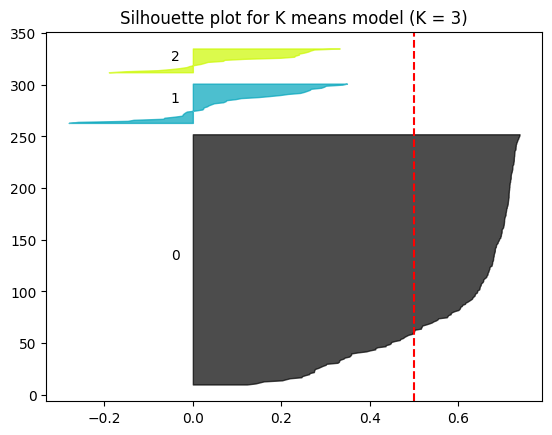

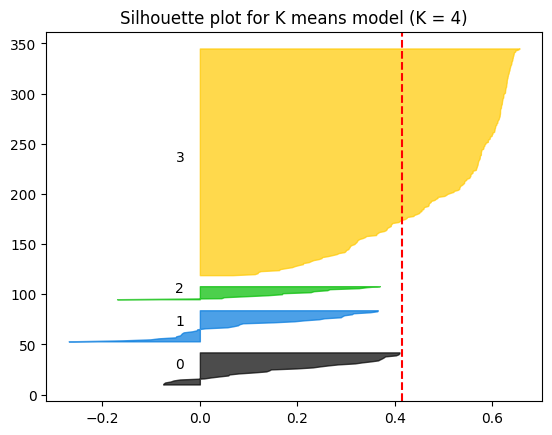

In [70]:
#k3_means_final_model_metrics = calculate_cluster_evaluation_metrics(non_zero_median_times_per_stage_df, k3_means_final_model_labels)
silhouette_values = metrics.silhouette_samples(non_zero_median_times_per_stage_df, k3_means_final_model_labels)
silhouette_scores = metrics.silhouette_score(non_zero_median_times_per_stage_df, k3_means_final_model_labels)
fig, ax = plot_silhouette_plot(k3_means_final_model_labels, silhouette_values, silhouette_scores, 3)
plt.title(f"Silhouette plot for K means model (K = 3)")
plt.show()

#k4_means_final_model_metrics = calculate_cluster_evaluation_metrics(non_zero_median_times_per_stage_df, k4_means_final_model_labels)
silhouette_values = metrics.silhouette_samples(non_zero_median_times_per_stage_df, k4_means_final_model_labels)
silhouette_scores = metrics.silhouette_score(non_zero_median_times_per_stage_df, k4_means_final_model_labels)
fig, ax = plot_silhouette_plot(k4_means_final_model_labels, silhouette_values, silhouette_scores, 4)
plt.title(f"Silhouette plot for K means model (K = 4)")
plt.show()

Evaluation metrics generally favour K=4, with the only metric lower for K=3 being the ASW. The silhouette plot for K=3 clearly shows some large differences in cluster 1. The K=4 model therefore seems more useful, especially with its TWCSS being lower too.

### K-Medoids

Improvements on K-means:
- Not constrained to Euclidean distance; other dissimilarity measures can be used.
- Less affected by outliers.
- Data doesn't have to be continuous.

We've already standardised and removed missing values, so the first thing to do is to visualise an elbow plot. We initially also tried this with the student DataFrame but the AWS's were incredibly low (generally < 0.2).

Here, we visualise different dissimilarity measures (euclidean, manhattan, and minkowski). We have to pre-create the dissimilarity matrices to do this.

In [143]:
K: int = 10
max_iter: int = 100
k_medoids_solutions: DataFrame = DataFrame(columns=["k", "Total within-cluster sum of squares", "Average silhouette width", "Dissimilarity measure", "DataFrame"])

i: int = 0
for dissimilarity_measure in ["euclidean", "manhattan", "minkowski"]:
    # Exercise attempts dataframe
    df = metrics.pairwise_distances(non_zero_median_times_per_stage_df, metric=dissimilarity_measure)
    for k in range(2, K + 1):
        k_medoids_intermediate = fastpam1(df, k, max_iter=max_iter)
        average_silhouette_score = metrics.silhouette_score(non_zero_median_times_per_stage_df, k_medoids_intermediate.labels, metric=dissimilarity_measure)
        k_medoids_solutions.loc[i] = [k, k_medoids_intermediate.loss, average_silhouette_score, dissimilarity_measure, "Non-zero median times per stage"]
        i += 1

    # Student dataframe
    df_student = metrics.pairwise_distances(student_median_times_per_stage_df, metric=dissimilarity_measure)
    for k in range(2, min(K + 1, len(student_median_times_per_stage_df))):
        k_medoids_intermediate = fastpam1(df_student, k, max_iter=max_iter)
        average_silhouette_score = metrics.silhouette_score(student_median_times_per_stage_df, k_medoids_intermediate.labels, metric=dissimilarity_measure)
        k_medoids_solutions.loc[i] = [k, k_medoids_intermediate.loss, average_silhouette_score, dissimilarity_measure, "Student median times per stage"]
        i += 1

px.line(
    k_medoids_solutions,
    x="k",
    y="Total within-cluster sum of squares",
    color="Dissimilarity measure",
    line_dash="DataFrame",
    title="Elbow plot for k-medoids clustering"
).show()

px.line(
    k_medoids_solutions,
    x="k",
    y="Average silhouette width",
    color="Dissimilarity measure",
    line_dash="DataFrame",
    title="Change in ASW for k-medoids clustering"
).show()

Although the clustering of the student dataset yields lower TWCSS, its ASW values are consistently low. Even after multiple runs, the ASW values rarely rise above 0.35. Hence the exercise attempts DataFrame is used from here.

#### Parameter Tuning

There's clearly not much of an elbow for this measure (and very little different between the euclidean and minkowski measures). However, the TWCSS for both of these dissimilarity measures are much lower than the K-means solutions, so the k=4 solution with euclidean distance is further explored.

In [144]:
df = metrics.pairwise_distances(non_zero_median_times_per_stage_df, metric="minkowski")

for init in ["random", "build"]:
    for max_iter in [1, 50, 100]:
        k_medoids = fastpam1(df, medoids=4, max_iter=max_iter, init=init)
        print(f"k=4: {init}, {max_iter}: {k_medoids.loss}")
    print()

k=4: random, 1: 319.7210409368527
k=4: random, 50: 295.0898763905475
k=4: random, 100: 298.26203965317467

k=4: build, 1: 295.873254404326
k=4: build, 50: 295.873254404326
k=4: build, 100: 295.873254404326



In [145]:
k_medoids_final_model = fastpam1(df, medoids=4, max_iter=50)
k_medoids_final_model_labels = k_medoids_final_model.labels
print(f"Clusters for k=4 model: {get_size_of_clusters(k_medoids_final_model_labels)}")

Clusters for k=4 model: {1: 98, 2: 49, 3: 31, 4: 128}


#### Evaluating Internal Cluster Quality
To decide whether to take these candidate solutions forward, we work out some evaluative statistics of these clusters.

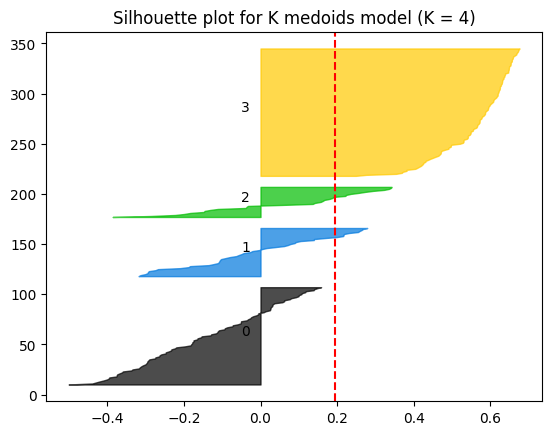

In [146]:
silhouette_values = metrics.silhouette_samples(non_zero_median_times_per_stage_df, k_medoids_final_model_labels)
silhouette_scores = metrics.silhouette_score(non_zero_median_times_per_stage_df, k_medoids_final_model_labels)
fig, ax = plot_silhouette_plot(k_medoids_final_model_labels, silhouette_values, silhouette_scores, 4)
plt.title(f"Silhouette plot for K medoids model (K = 4)")
plt.show()

### Agglomerative Hierarchical Clustering

Procedure:
- Try a variation of linkage criteria and dissimilarity measures.
- Visualise the dendrogram and cut at the most appropriate places (could cut at several points).

After a manual inspection the following combinations of parameters:
- Any model with single linkage
- Average linkage and city block dissimilarity
- Average linkage and minkowski dissimilarity

**Do standardised values need to be used here?**

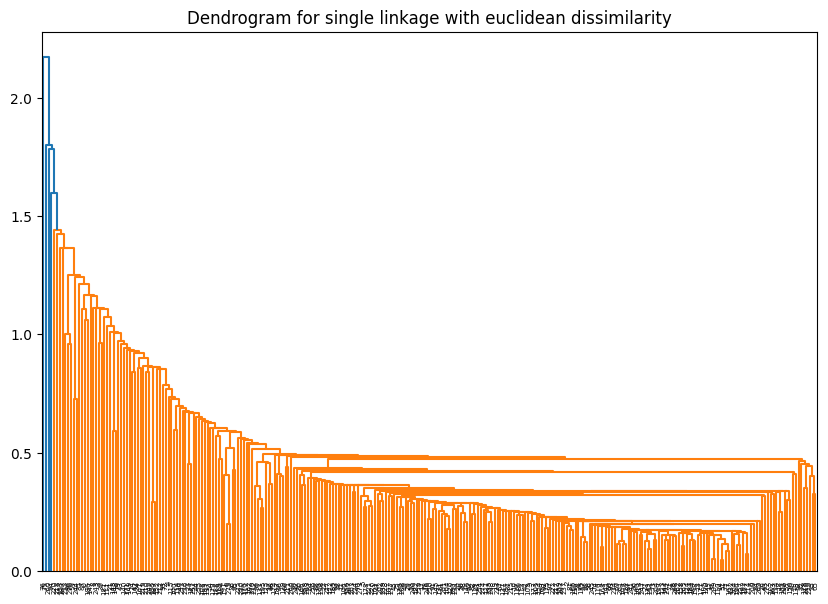

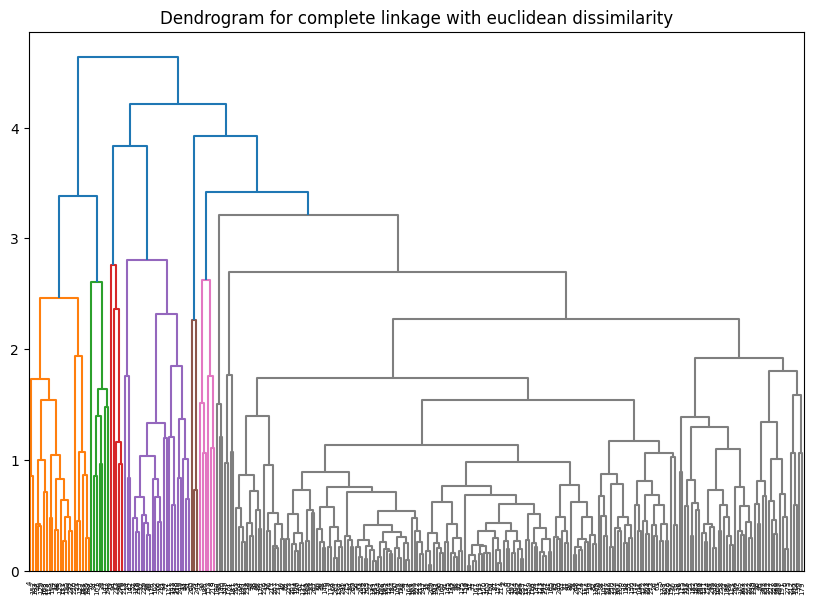

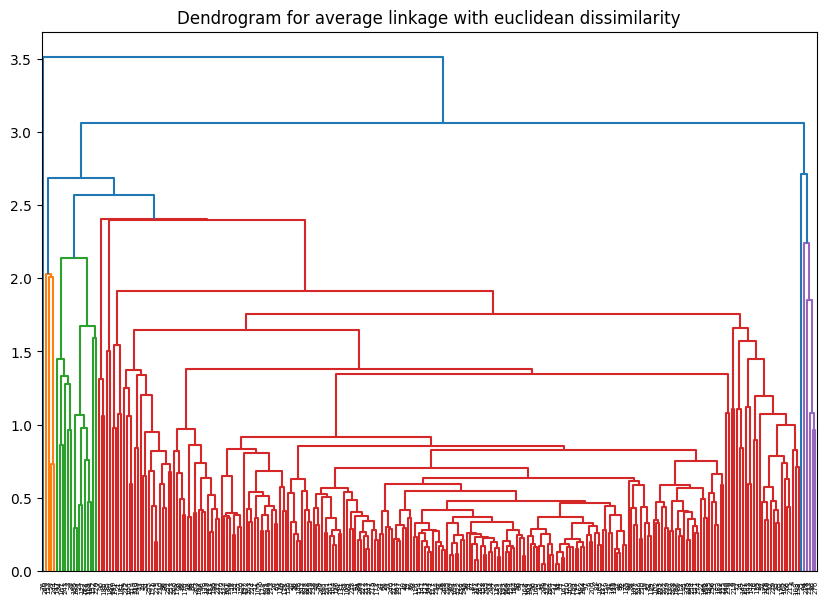

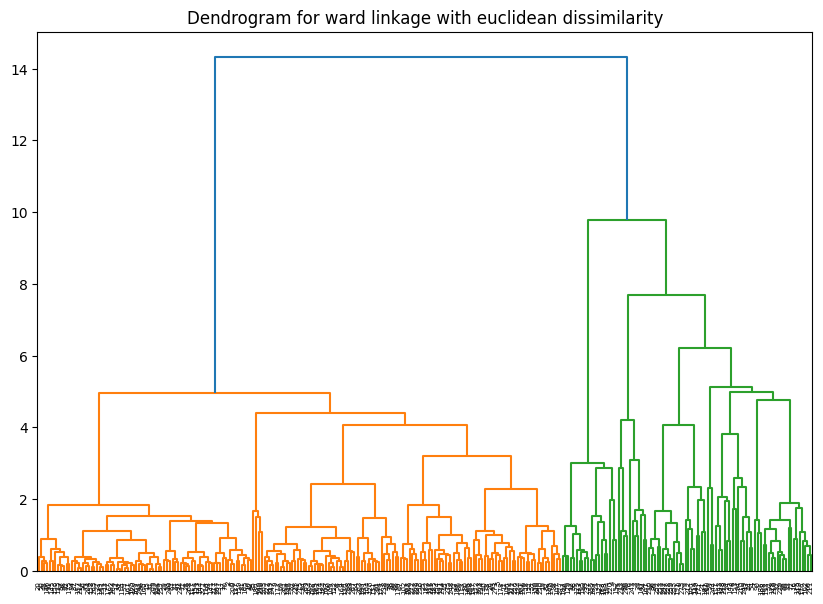

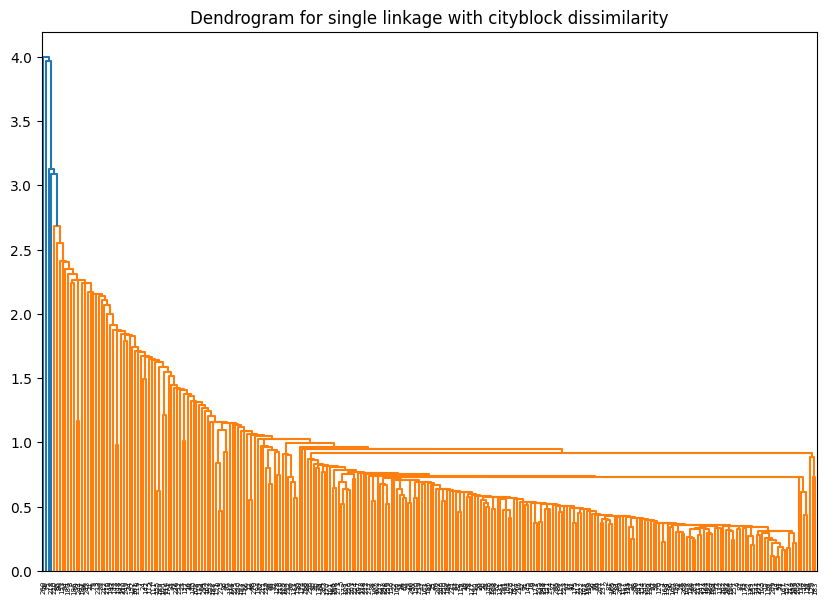

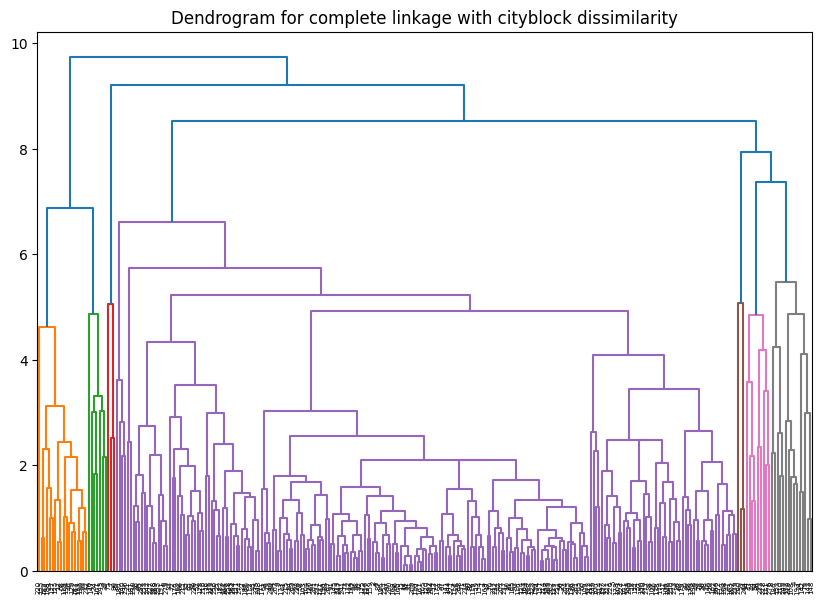

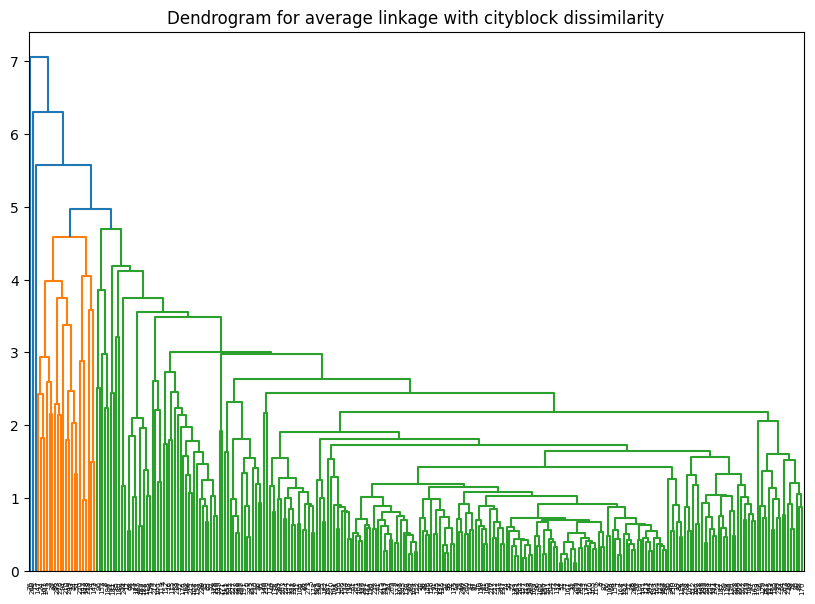

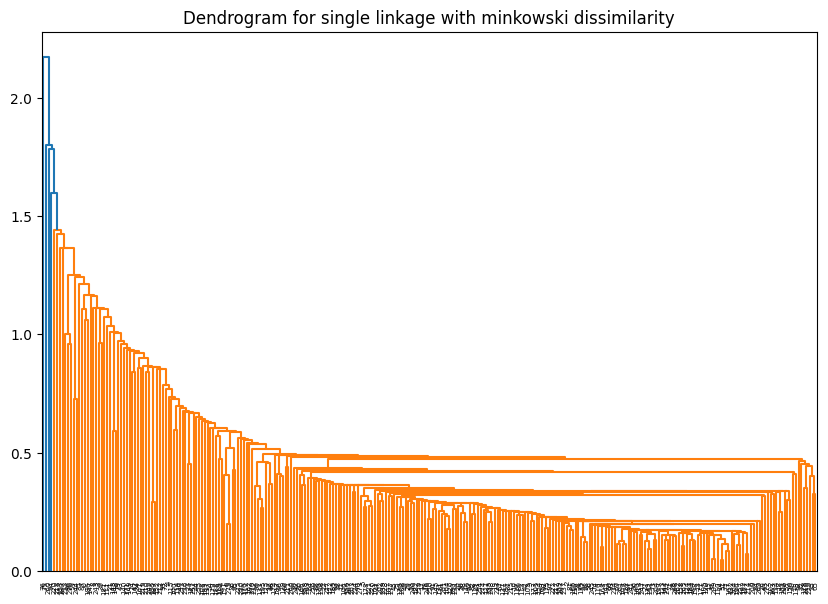

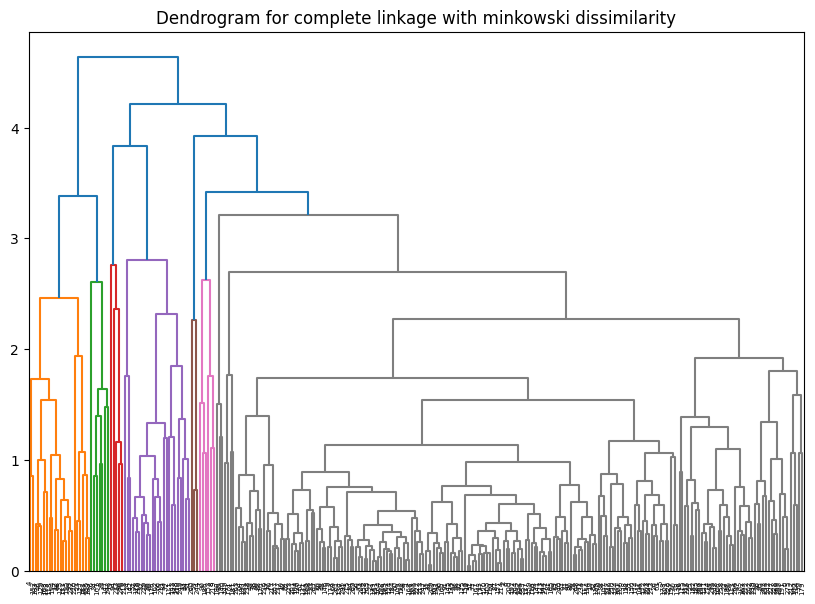

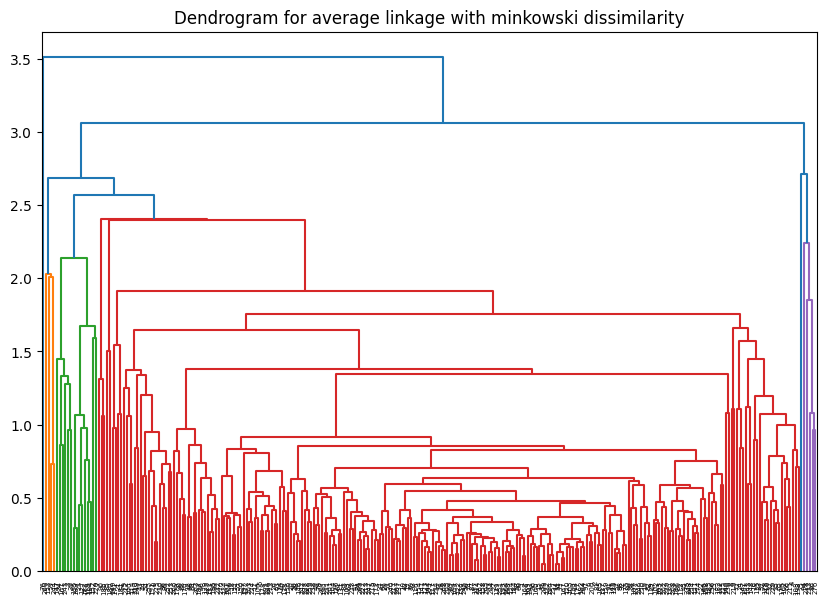

In [23]:
linkage_methods: list[str] = ["single","complete", "average", "ward"]
for dissimilarity_measure in ["euclidean", "cityblock", "minkowski"]:
    for linkage_method in linkage_methods:
        if (linkage_method == "ward" and dissimilarity_measure != "euclidean"):
            continue  # Ward only works with Euclidean distance
        plt.figure(figsize=(10, 7))
        linkage_model = linkage(non_zero_median_times_per_stage_df, method=linkage_method, metric=dissimilarity_measure)
        plt.title(f"Dendrogram for {linkage_method} linkage with {dissimilarity_measure} dissimilarity")
        dendrogram(linkage_model)
        plt.show()

For student dataset

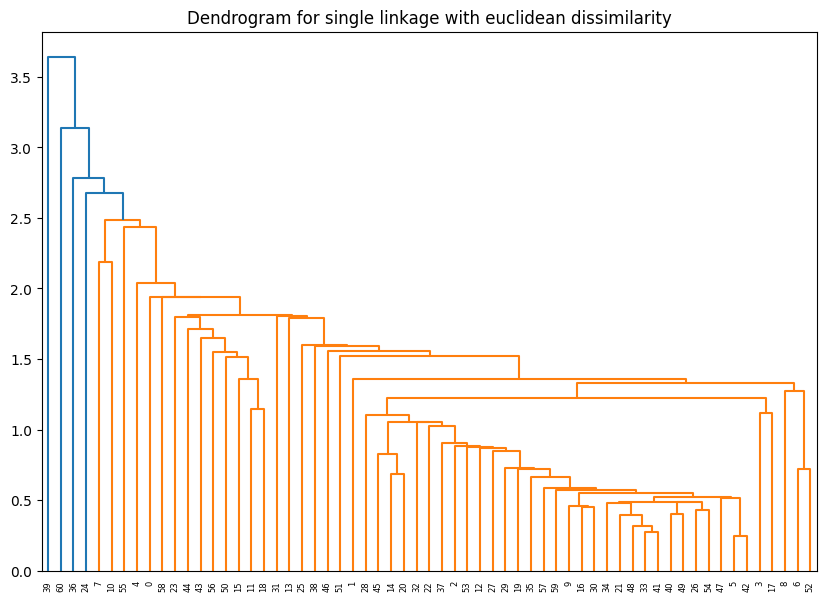

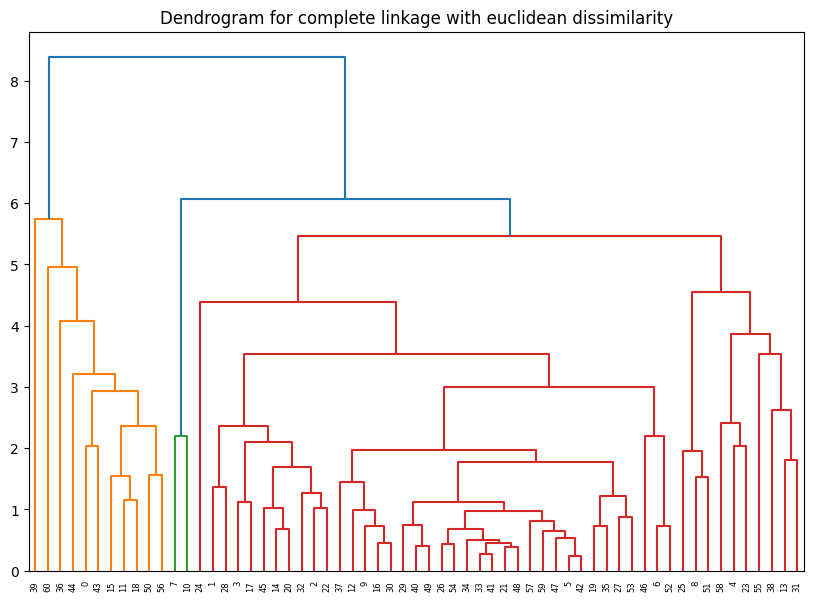

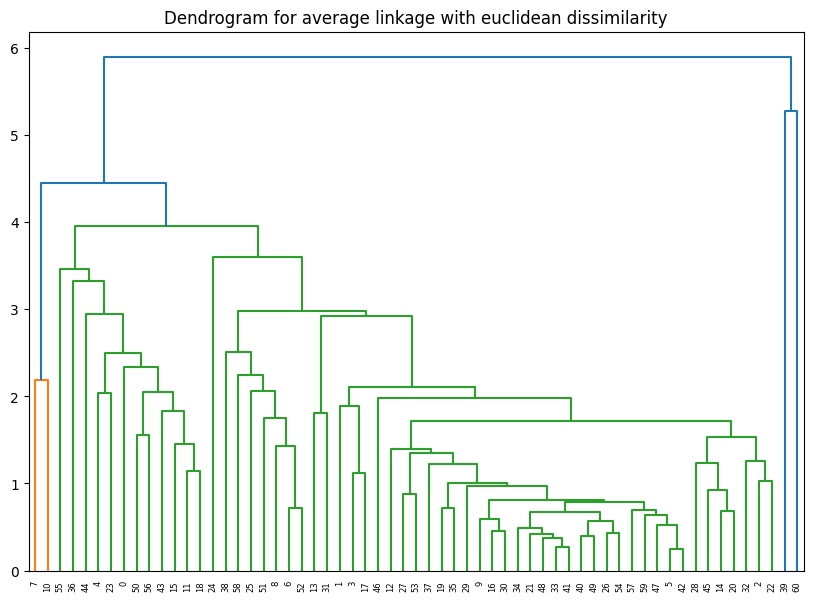

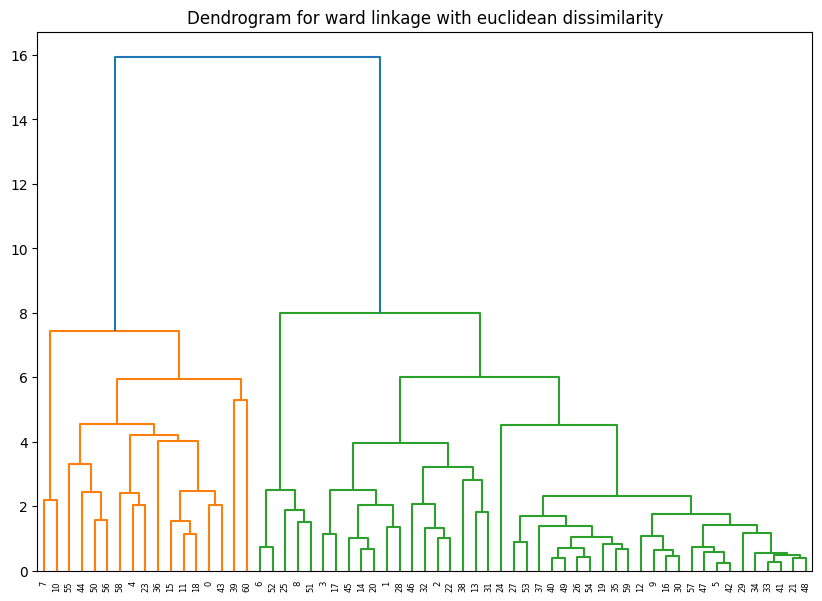

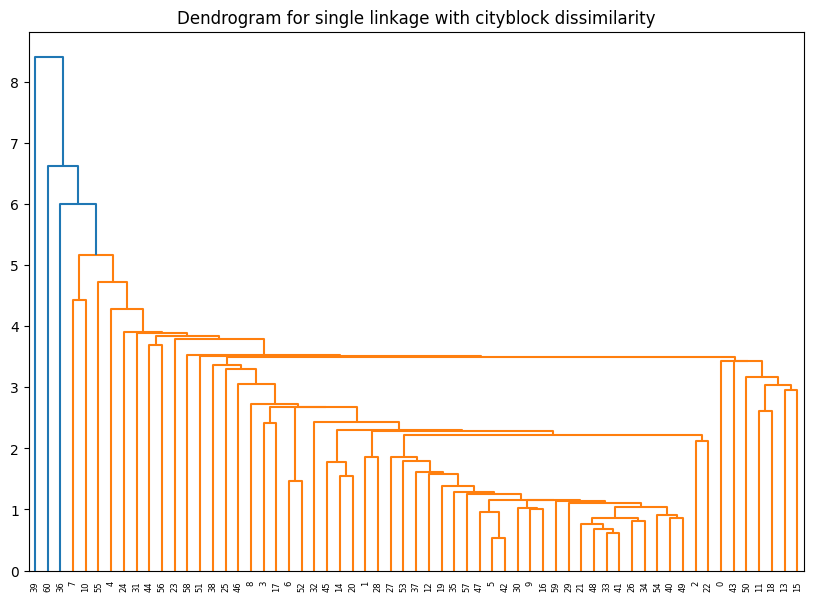

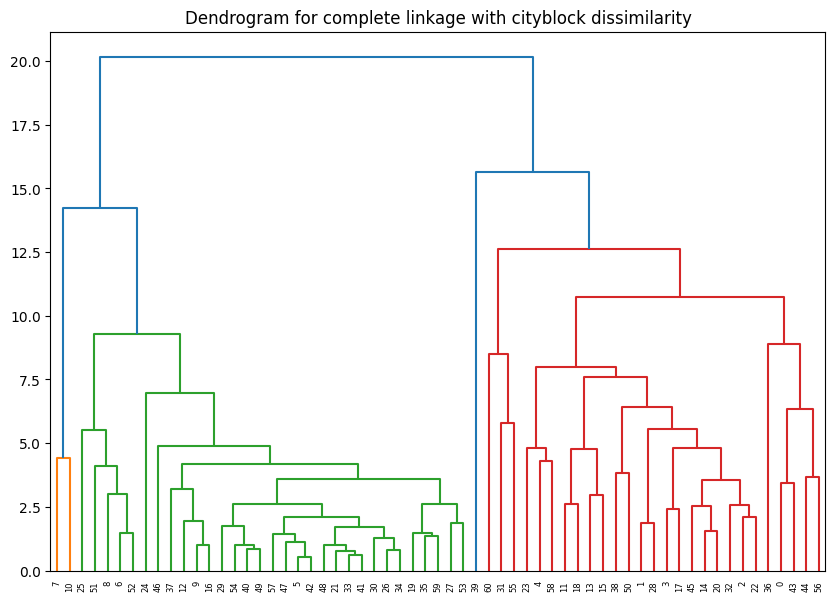

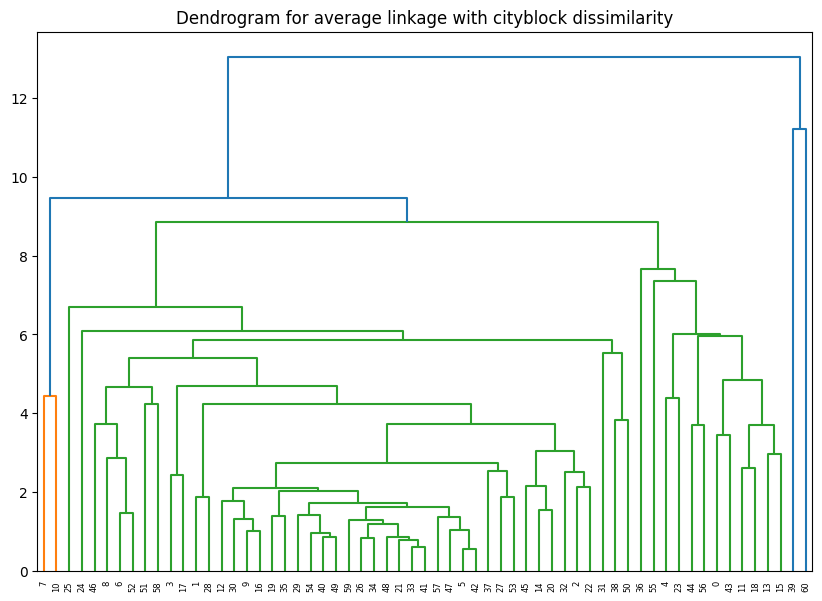

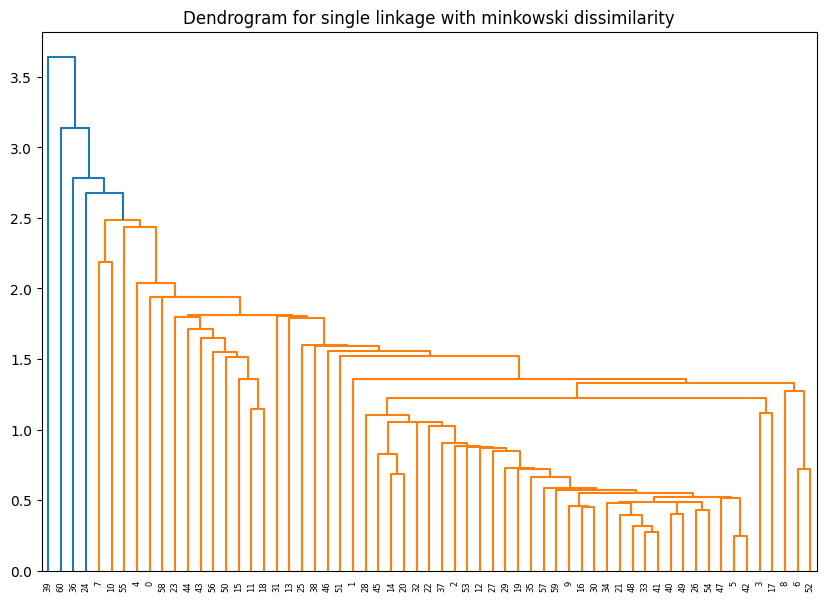

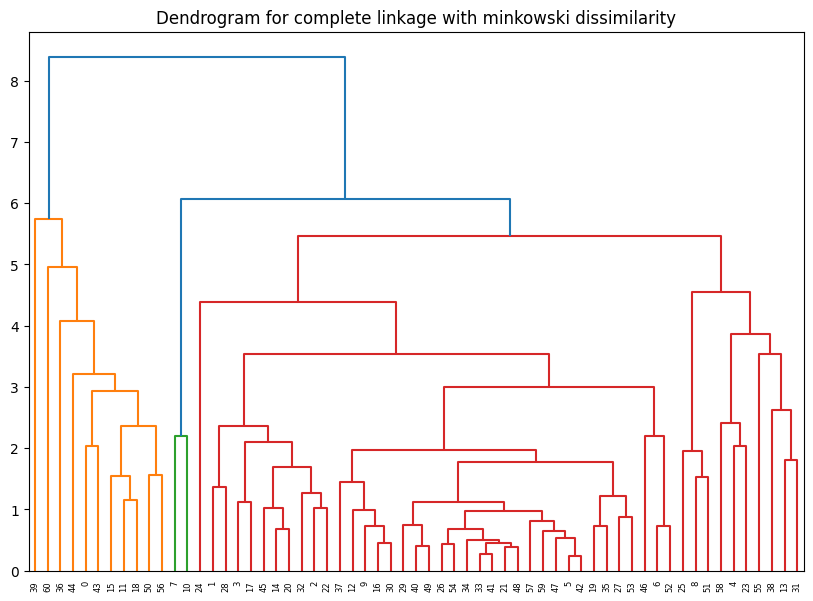

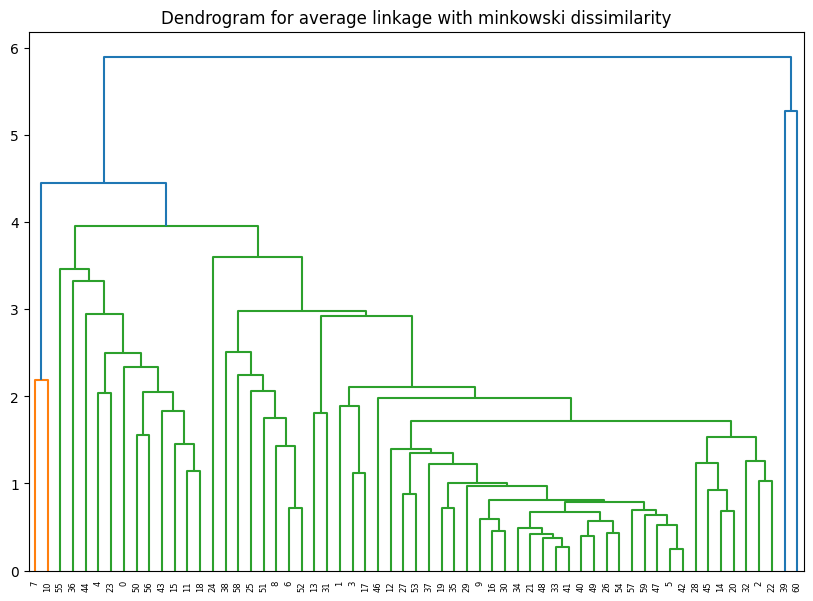

In [147]:
linkage_methods: list[str] = ["single","complete", "average", "ward"]
for dissimilarity_measure in ["euclidean", "cityblock", "minkowski"]:
    for linkage_method in linkage_methods:
        if (linkage_method == "ward" and dissimilarity_measure != "euclidean"):
            continue  # Ward only works with Euclidean distance
        plt.figure(figsize=(10, 7))
        linkage_model = linkage(student_median_times_per_stage_df, method=linkage_method, metric=dissimilarity_measure)
        plt.title(f"Dendrogram for {linkage_method} linkage with {dissimilarity_measure} dissimilarity")
        dendrogram(linkage_model)
        plt.show()

#### Selecting candidate solutions

Now we have plotted several dendrograms, we can remove some through visual inspection:
- All solutions where `linkage_method = "single"` produces undesirable chaining effects.
- `{linkage_method: "average", dissimilarity_measure: "euclidean"}` as this generates a huge cluster (coloured red in the dendogram) and several other very small clusters.
- `{linkage_method: "average", dissimilarity_measure: "cityblock"}` produces an undesirable chaining effect.
- `{linkage_method: "average", dissimilarity_measure: "minkowski"}` suffers from the same problem as the cluster with `{linkage_method: "average", dissimilarity_measure: "euclidean"}`.

This means we move on with the models in the `candidate_models` list below. Some of these could be cut at different points; the number of clusters that should be evaluated is indicated by the `k` variable in `candidate_models`. We generate cluster models based on each of these and evaluate them using:


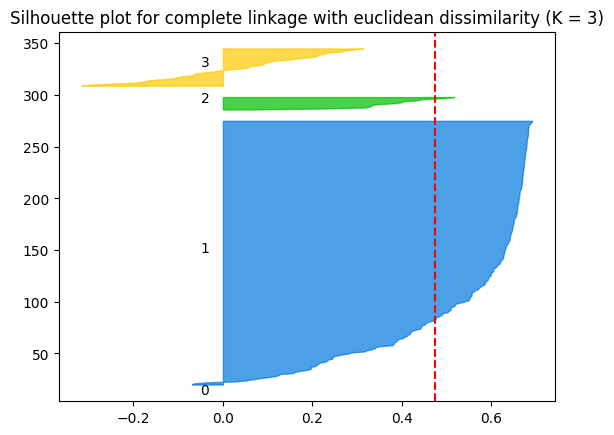

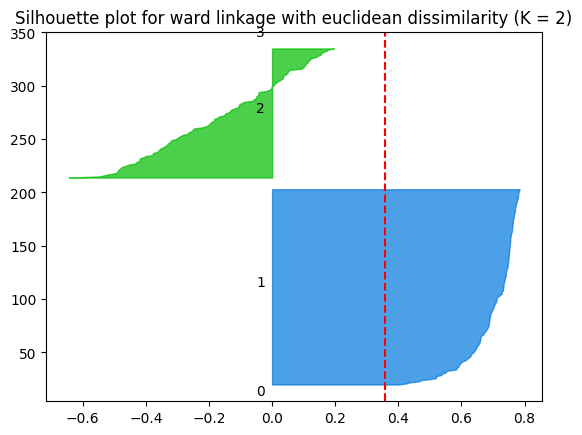

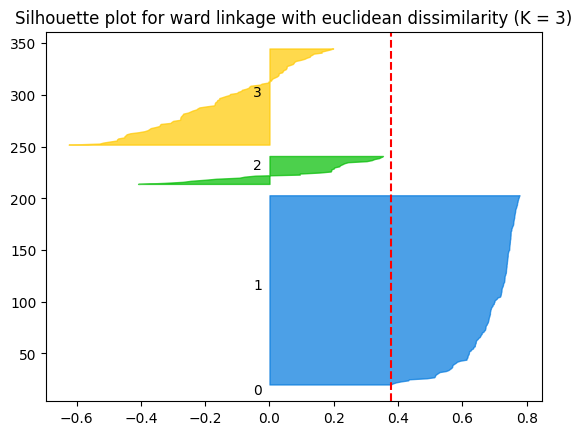

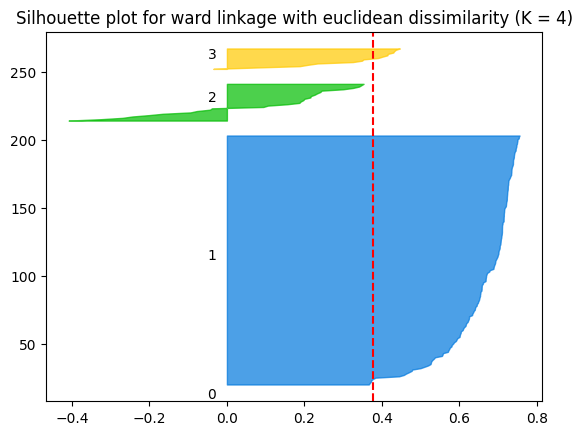

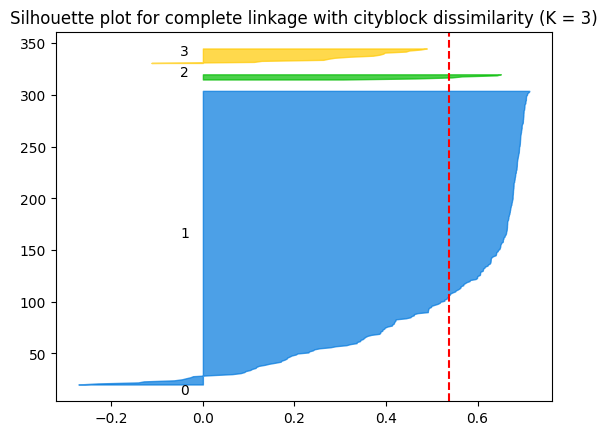

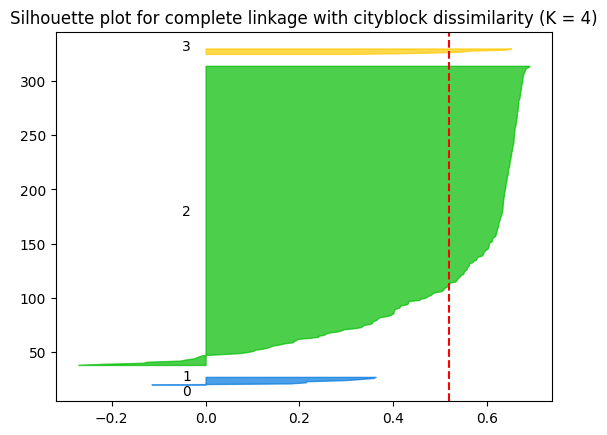

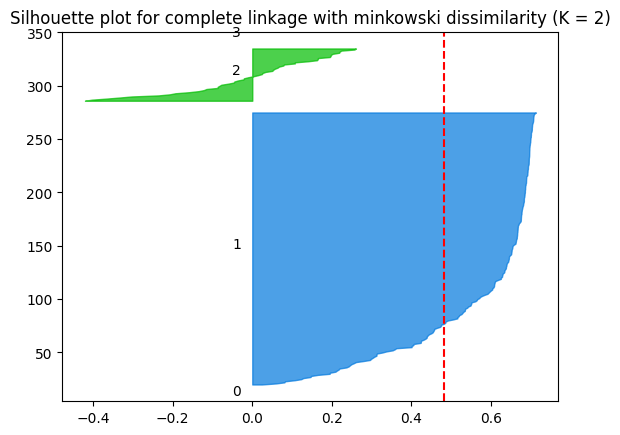

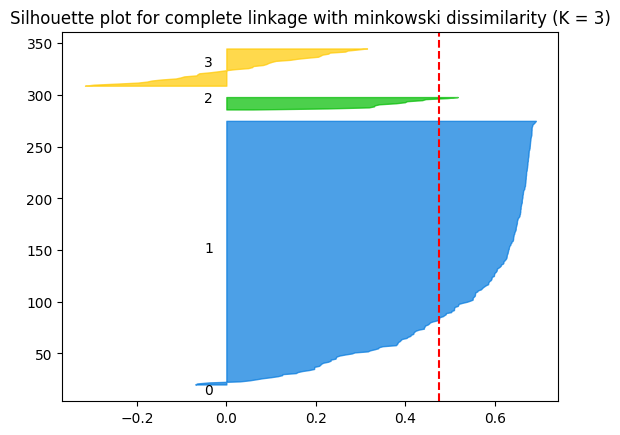

In [100]:
candidate_models: list[dict[str, str]] = [{
    "linkage_method": "complete",
    "dissimilarity_measure": "euclidean",
    "n_clusters": [3]
},
{
    "linkage_method": "ward",
    "dissimilarity_measure": "euclidean",
    "n_clusters": [2, 3, 4]
},
{
    "linkage_method": "complete",
    "dissimilarity_measure": "cityblock",
    "n_clusters": [3, 4]
},
{
    "linkage_method": "complete",
    "dissimilarity_measure": "minkowski",
    "n_clusters": [2, 3]
}]

for model in candidate_models:
    for n_clusters in model["n_clusters"]:
        linkage_model = linkage(non_zero_median_times_per_stage_df, method=model["linkage_method"], metric=model["dissimilarity_measure"])
        cluster_labels = fcluster(linkage_model, n_clusters, criterion='maxclust')
        silhouette_values = metrics.silhouette_samples(non_zero_median_times_per_stage_df, cluster_labels)
        silhouette_scores = metrics.silhouette_score(non_zero_median_times_per_stage_df, cluster_labels)
        fig, ax = plot_silhouette_plot(cluster_labels, silhouette_values, silhouette_scores, 4)
        plt.title(f"Silhouette plot for {model['linkage_method']} linkage with {model['dissimilarity_measure']} dissimilarity (K = {n_clusters})")
        plt.show()

For student dataset

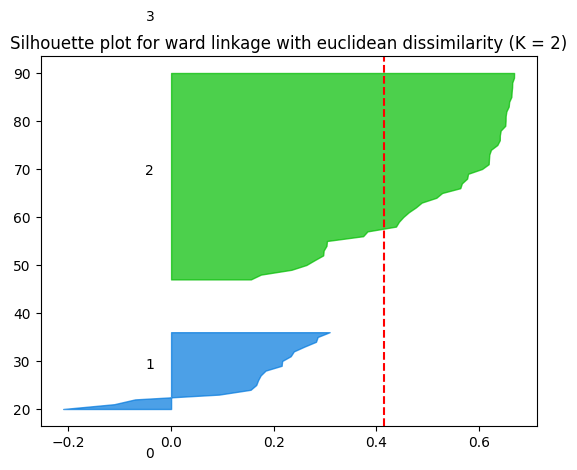

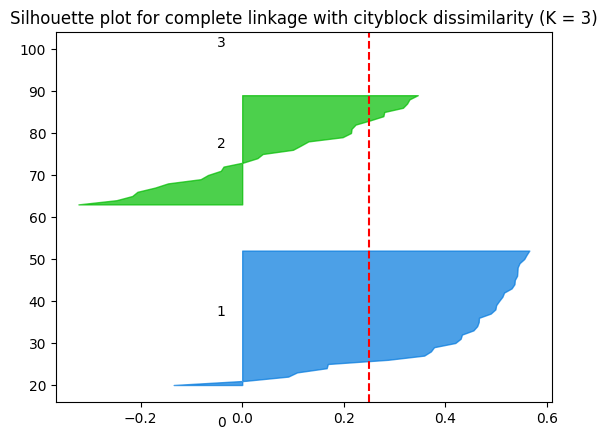

In [149]:
candidate_models: list[dict[str, str]] = [{
    "linkage_method": "ward",
    "dissimilarity_measure": "euclidean",
    "n_clusters": [2]
},
{
    "linkage_method": "complete",
    "dissimilarity_measure": "cityblock",
    "n_clusters": [3]
}]

for model in candidate_models:
    for n_clusters in model["n_clusters"]:
        linkage_model = linkage(student_median_times_per_stage_df, method=model["linkage_method"], metric=model["dissimilarity_measure"])
        cluster_labels = fcluster(linkage_model, n_clusters, criterion='maxclust')
        silhouette_values = metrics.silhouette_samples(student_median_times_per_stage_df, cluster_labels)
        silhouette_scores = metrics.silhouette_score(student_median_times_per_stage_df, cluster_labels)
        fig, ax = plot_silhouette_plot(cluster_labels, silhouette_values, silhouette_scores, 4)
        plt.title(f"Silhouette plot for {model['linkage_method']} linkage with {model['dissimilarity_measure']} dissimilarity (K = {n_clusters})")
        plt.show()

Again, the combination of the small clusters and ASW < 0.4 doesn't favour the investigation of the student clusters. None of these solutions are taken forward as a result.

#### Evaluating Internal Cluster Quality
Now we've experimented with different clusters, we narrow down our clustering models and perform some final evaluation on the following AHC
- Ward linkage (K = 4)
- Complete linkage with cityblock similarity (K = 4)

We calculate the following evaluation metrics for each clustering model.
- Average Silhouette Width
- Point Biserial Correlation
- Hubert's C
In order to calculate the latter two metrics, we need to import the weighted

In [26]:
#weightedcluster = importr('WeightedCluster')

ahc_ward_model = linkage(non_zero_median_times_per_stage_df, method="ward")
ahc_ward_model_labels = fcluster(ahc_ward_model, 4, criterion='maxclust')
#ahc_ward_model_labels_metrics = calculate_cluster_evaluation_metrics(non_zero_median_times_per_stage_df, ahc_ward_model_labels)

ahc_complete_linkage_cityblock = linkage(non_zero_median_times_per_stage_df, method="ward")
ahc_complete_linkage_cityblock_labels = fcluster(ahc_complete_linkage_cityblock, 4, criterion='maxclust')
#ahc_complete_linkage_cityblock_metrics = calculate_cluster_evaluation_metrics(non_zero_median_times_per_stage_df, ahc_complete_linkage_cityblock_labels, "cityblock")

"""
for metrics in [k_means_final_model_metrics, ahc_ward_model_labels_metrics, ahc_complete_linkage_cityblock_metrics]:
    print("Evaluation metrics:")
    print(f"Point Biserial correlation coefficient: {metrics["point_biserial_correlation"]:.2f}")
    print(f"Average silhouette width: {metrics["average_silhouette_width"]:.2f}")
    print(f"Hubert's C: {metrics["huberts_c"]:.2f}\n")
"""

'\nfor metrics in [k_means_final_model_metrics, ahc_ward_model_labels_metrics, ahc_complete_linkage_cityblock_metrics]:\n    print("Evaluation metrics:")\n    print(f"Point Biserial correlation coefficient: {metrics["point_biserial_correlation"]:.2f}")\n    print(f"Average silhouette width: {metrics["average_silhouette_width"]:.2f}")\n    print(f"Hubert\'s C: {metrics["huberts_c"]:.2f}\n")\n'

In [28]:
import pandas as pd

pd.DataFrame({"exercise_log_id": non_zero_median_times_per_stage_df.index, "label": ahc_ward_model_labels}).to_csv("data/temp/ahc_ward_model_labels.csv", index=False)
pd.DataFrame({"exercise_log_id": non_zero_median_times_per_stage_df.index, "label": ahc_complete_linkage_cityblock_labels}).to_csv("data/temp/ahc_complete_linkage_cityblock_labels.csv", index=False)

The metrics of these two clusters are again similar, so before deciding on which one to use, we perform further evaluation through comparing clusters

### Model-Based Clustering
Currently being implemented in `r_clustering.ipynb`

### Final Evaluation: Comparing Clusters
We now have a set of cluster models listed below:
- K Means model (K = 3)
- K Means model (K = 4)
- Ward linkage (K = 4)
- Complete linkage with cityblock similarity (K = 4)

We compare the cluster centroids (for the K-means models) and the median time spent on each PRIMMDebug stage (for the AHC models) to see if they are similar. This acts as a step of evaluation, as their similarity helps point to whether the clustering has consistently revealed some underlying structure.

In [29]:
from pandas import read_csv

exercise_logs_to_clusters_k3_means: DataFrame = DataFrame()
exercise_logs_to_clusters_k3_means.name = "K Means (K=3)"
exercise_logs_to_clusters_k3_means["exercise_log_id"] = non_zero_median_times_per_stage_df.index
exercise_logs_to_clusters_k3_means["cluster"] = [i+1 for i in k3_means_final_model_labels]

exercise_logs_to_clusters_k4_means: DataFrame = DataFrame()
exercise_logs_to_clusters_k4_means.name = "K Means (K=4)"
exercise_logs_to_clusters_k4_means["exercise_log_id"] = non_zero_median_times_per_stage_df.index
exercise_logs_to_clusters_k4_means["cluster"] = [i+1 for i in k4_means_final_model_labels]

exercise_logs_to_clusters_ahc_ward: DataFrame = DataFrame()
exercise_logs_to_clusters_ahc_ward.name = "AHC with Ward"
exercise_logs_to_clusters_ahc_ward["exercise_log_id"] = non_zero_median_times_per_stage_df.index
exercise_logs_to_clusters_ahc_ward["cluster"] = ahc_ward_model_labels

exercise_logs_to_clusters_ahc_complete_linkage: DataFrame = DataFrame()
exercise_logs_to_clusters_ahc_complete_linkage.name = "AHC Complete Linkage (Cityblock)"
exercise_logs_to_clusters_ahc_complete_linkage["exercise_log_id"] = non_zero_median_times_per_stage_df.index
exercise_logs_to_clusters_ahc_complete_linkage["cluster"] = ahc_complete_linkage_cityblock_labels

exercise_logs_to_clusters_model_based: DataFrame = read_csv("data/temp/model_based_cluster_labels.csv")
exercise_logs_to_clusters_model_based.name = "Model-Based Clustering"

for df in [exercise_logs_to_clusters_k3_means, exercise_logs_to_clusters_k4_means, exercise_logs_to_clusters_ahc_ward, exercise_logs_to_clusters_ahc_complete_linkage, exercise_logs_to_clusters_model_based]:
    plot_median_times_per_stage_of_clusters(df, EXERCISE_LOGS, model_name=df.name)

median_times_per_stage_model_based: DataFrame = read_csv("data/temp/model_based_cluster_means.csv", index_col=0)
median_times_per_stage_model_based = DataFrame(scaler.inverse_transform(median_times_per_stage_model_based), index=median_times_per_stage_model_based.index, columns=median_times_per_stage_model_based.columns)
# Convert median_times_per_stage_model_based to long-form DataFrame with columns: cluster, stage, time
median_times_per_stage_model_based_long = median_times_per_stage_model_based.reset_index().melt(
    id_vars="index",
    var_name="stage",
    value_name="time"
).rename(columns={"index": "cluster"})
median_times_per_stage_model_based_long["cluster"] = median_times_per_stage_model_based_long["cluster"].astype(str)
px.bar(median_times_per_stage_model_based_long, x="stage", y="time", color="cluster", barmode="group", title="Estimated means from model-based clustering").show()

A positive sign is that for each of the 4-cluster models, the average times for each stage is similar. This acts as further confirmation of the applicability of a clustering solution where K=4. We now move onto to selecting a final model to properly investigate.

### Selecting Final Cluster Solution

## Investigating the clusters
Now we've obtained some clustering solutions, we see how exercise attempts within each cluster correlate to:
- Success on exercise attempts (whether final program passed test harnesses)
- Median time on PRIMMDebug challenge
- Median time on each PRIMMDebug stage
- Number of stages

### K means model

In [45]:
print(f"Size of clusters: {get_size_of_clusters(k4_means_final_model_labels)}")

plot_median_number_of_stages_of_clusters(exercise_logs_to_clusters_k4_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k4_means.name)
plot_median_times_per_stage_of_clusters(exercise_logs_to_clusters_k4_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k4_means.name)
plot_median_times_per_exercise_of_clusters(exercise_logs_to_clusters_k4_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k4_means.name)
plot_session_data_of_clusters(exercise_logs_to_clusters_k4_means, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_k4_means.name)

Size of clusters: {1: 190, 2: 23, 3: 28, 4: 37}


### Model-based model

In [43]:
plot_correctness_of_clusters(exercise_logs_to_clusters_model_based, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_model_based.name)
plot_median_number_of_stages_of_clusters(exercise_logs_to_clusters_model_based, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_model_based.name)
plot_median_times_per_stage_of_clusters(exercise_logs_to_clusters_model_based, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_model_based.name)
plot_median_times_per_exercise_of_clusters(exercise_logs_to_clusters_model_based, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_model_based.name)
plot_session_data_of_clusters(exercise_logs_to_clusters_model_based, EXERCISE_LOGS, model_name=exercise_logs_to_clusters_model_based.name)

### Interpretation of the clusters

## Contextual Information
Analysis that doesn't fit into the current framework but might come in handy later.

### Number of stages taken for a PRIMMDebug challenge
- Per exercise
- Per student

In [ ]:


#Median number of stages that each student took on the PRIMMDebug challenges they attempted
average_stages_per_student: list[int] = []
for student in STUDENT_IDS:
    student_EXERCISE_LOGS: list[ExerciseLog] = [exercise for exercise in EXERCISE_LOGS if exercise.student_id == student.id]
    if len(student_EXERCISE_LOGS) > 0:
        average_stages_per_student.append(median([len(exercise.stage_logs) for exercise in student_EXERCISE_LOGS]))
average_stages_per_student_fig = px.histogram(average_stages_per_student, marginal="box", labels={"value": "Median number of stages per student", "count": "Count"})
average_stages_per_student_fig.show()

### Program Log Stats
For relevant PRIMMDebug stages that contain program logs

In [ ]:
number_of_runs_inspect_the_code_and_test: list[int] = [StageLogProcessor.get_number_of_runs(stage_log) for stage_log in STAGE_LOGS if stage_log.stage_name in [DebuggingStage.inspect_code, DebuggingStage.test] and StageLogProcessor.get_number_of_runs(stage_log) > 0] #Remove stages where there's 0 runs
number_of_runs_inspect_the_code: list[int] = [StageLogProcessor.get_number_of_runs(stage_log) for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.inspect_code and StageLogProcessor.get_number_of_runs(stage_log) > 0]
number_of_runs_test: list[int] = [StageLogProcessor.get_number_of_runs(stage_log) for stage_log in STAGE_LOGS if stage_log.stage_name == DebuggingStage.test and StageLogProcessor.get_number_of_runs(stage_log) > 0]
number_of_runs_fig = px.histogram(number_of_runs_inspect_the_code_and_test, marginal="box", labels={"x": "Time taken (seconds)"})
number_of_runs_fig.show()

time_between_runs: list[float] = [time for stage_log in STAGE_LOGS if stage_log.stage_name in [DebuggingStage.inspect_code, DebuggingStage.test] for time in StageLogProcessor.get_time_between_runs(stage_log) if StageLogProcessor.get_time_between_runs(stage_log) != []]
time_between_runs_fig = px.histogram(time_between_runs, marginal="box", labels={"x": "Time between runs (seconds)"})
time_between_runs_fig.show()

runs_per_minute: list[float] = [round(StageLogProcessor.get_runs_per_minute(stage_log), 2) for stage_log in STAGE_LOGS if stage_log.stage_name in [DebuggingStage.inspect_code, DebuggingStage.test]]
print(f"Runs per minute for inspect the code/test stages: {runs_per_minute}")

number_of_inputs: list[list[int]] = [StageLogProcessor.get_number_of_inputs_from_runs(stage_log) for stage_log in STAGE_LOGS if stage_log.stage_name in [DebuggingStage.inspect_code, DebuggingStage.test]]
print(f"Number of inputs per stage for test stages: {number_of_inputs}")

## References
- Everitt, B.S., Landau, S., Leese, M. and Stahl, D., 2011. Cluster analysis 5th edition Wiley.
- Frades I, Matthiesen R. Overview on techniques in cluster analysis. Methods Mol Biol. 2010;593:81-107. doi: 10.1007/978-1-60327-194-3_5. PMID: 19957146.
- Kassambara, A. (2017). Practical guide to cluster analysis in R: Unsupervised machine learning (Vol. 1). Sthda.
- Keefe Murphy, Sonsoles López-Pernas, Mohammed Saqr (2024). Dissimilarity-based Cluster Analysis of Educational Data: A Comparative Tutorial using R. In M. Saqr & S. López-Pernas (Eds.), Learning analytics methods and tutorials: A practical guide using R   (pp. 231-283).Springer, Cham. doi: 10.1007/978-3-031-54464-4_8
- Saqr, M. et al. (2024). Sequence Analysis in Education: Principles, Technique, and Tutorial with R. In: Saqr, M., López-Pernas, S. (eds) Learning Analytics Methods and Tutorials. Springer, Cham. https://doi.org/10.1007/978-3-031-54464-4_10
- Studer, Matthias (2013). WeightedCluster Library Manual: A practical guide to creating typologies of trajectories in the social sciences with R. LIVES Working Papers, 24. DOI: http://dx.doi.org/10.12682/lives.2296-1658. 2013.24.


# Appendix

## Save logs